In [1]:
import sys
import cProfile
sys.path.append( "../../pyext/src" )
import scoring
import sampling
import system
import model
import hxio
import tools
import analysis
import plots


import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#pof = analysis.ParseOutputFile("./output/models_scores_sigmas-Ribose1.dat")
pof = analysis.ParseOutputFile('./output/models_scores_sigmas-ADP_1.dat')
#pof2 = analysis.ParseOutputFile("./output/models_scores_sigmas-Ribose2.dat")
pof2 = analysis.ParseOutputFile("./output/models_scores_sigmas-PEP_1.dat")

pof.generate_datasets()
pof2.generate_datasets()
pof.calculate_random_sample_convergence()
pof2.calculate_random_sample_convergence()

conv = analysis.Convergence(pof, pof2)

print(conv.total_score_pvalue_and_cohensd())
print(conv.residue_pvalue_and_cohensd())

(0.1, 1073.3421269388705, 2.513456617709399) 2336
(0.2, 1072.1868248366309, 2.2572836396303075) 4672
(0.30000000000000004, 1071.5727099423336, 1.924685666624012) 7008
(0.4, 1070.9999041966073, 1.5899184893376674) 9344
(0.5, 1070.7623974807182, 1.454050770480811) 11681
(0.6, 1070.279989580826, 1.368446468109771) 14017
(0.7000000000000001, 1070.0944589845508, 1.2008652093074428) 16353
(0.8, 1069.8084949966371, 1.0120572065933022) 18689
(0.9, 1069.6079650648314, 0.761255222450755) 21025
(0.1, 1120.214508426837, 2.8974374899715465) 510
(0.2, 1118.7476183930628, 1.762453056406204) 1020
(0.30000000000000004, 1117.9074791660664, 1.2415547281036465) 1530
(0.4, 1117.486849291184, 0.6728132831358932) 2040
(0.5, 1117.2776267559398, 0.40243399500599014) 2550
(0.6, 1117.2601827011051, 0.4554251605627175) 3060
(0.7000000000000001, 1117.1333910942014, 0.23810435680444336) 3570
(0.8, 1117.1065313868335, 0.2056928207816589) 4080
(0.9, 1117.0362441849327, 0.12183723735710912) 4590
(0.0, -3.6804252656656

In [10]:

#plots.plot_residue_protection_factors([pof, pof2], num_best_models=500, sort_sectors=True)

/home/chenlin/anaconda3/envs/MD/lib/python3.10/site-packages/scipy/stats/_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
/home/chenlin/anaconda3/envs/MD/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


num_significant 223


<Axes: >

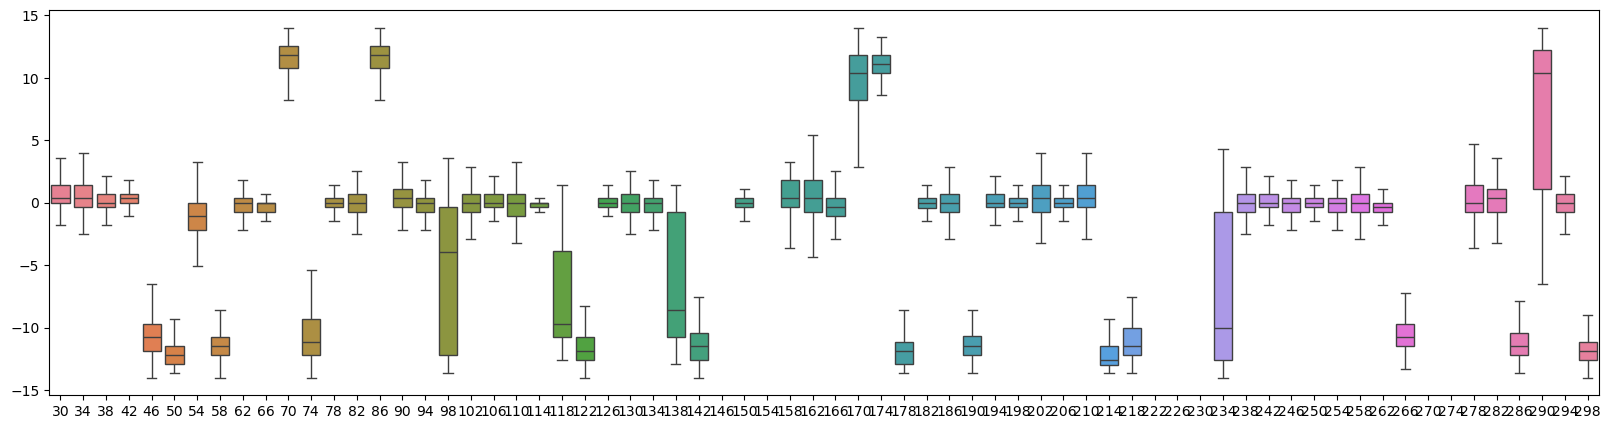

In [3]:
def get_pf_list(pof_list):
    data_list = []
    for po in pof_list:
        data_list.append(po.get_best_scoring_models(500, return_pf=True, sort_sectors=True))

    pf_list = []
    # pf_list is an array of models
    for d in data_list:
        pfs = []   
        # Loop over all models in this list     
        for i in d:
            # Append just the model itself. 
            pfs.append(np.array(i[1][0]))
        pf_list.append(np.array(pfs))

    return pf_list


import numpy as np
from scipy import stats

def if_significantly_different(dataset1, dataset2, alpha=0.05, print_p_value=False):
    """
    Test if two datasets are significantly different using the two-sample t-test.

    Returns:
    bool: True if the datasets are significantly different, False otherwise.
    """
    # Check if the datasets are normally distributed using the Shapiro-Wilk test
    _, p_value_shapiro1 = stats.shapiro(dataset1)
    _, p_value_shapiro2 = stats.shapiro(dataset2)

    if p_value_shapiro1 > alpha and p_value_shapiro2 > alpha:
        # If both datasets are normally distributed, use the two-sample t-test
        _, p_value = stats.ttest_ind(dataset1, dataset2)
    else:
        # If either dataset is not normally distributed, use the Mann-Whitney U test
        _, p_value = stats.mannwhitneyu(dataset1, dataset2)

    # If the p-value is less than the significance level, the datasets are significantly different
    if print_p_value:
        print("p-value: {}".format(p_value))
    return p_value < alpha





pf_list = get_pf_list([pof, pof2])

df_list = []
for pf in pf_list:
    df = pd.DataFrame(pf)
    df_list.append(df)

diff = df_list[0] - df_list[1]
diff_mean = df_list[0].mean() - df_list[1].mean()

# test the significance of each column
num_significant = 0
for i in df_list[0].columns:
    if not if_significantly_different(df_list[0][i], df_list[1][i]):
        diff_mean[i] = 0
    else:
        num_significant += 1
        #if_significantly_different(df_list[0][i], df_list[1][i], print_p_value=True)
print('num_significant',num_significant )

data_slices = [
    (slice(0, 50), slice(0, 50)),
    (slice(50, 100), slice(50, 100)),
    (slice(100, 150), slice(100, 150)),
    (slice(150, 200), slice(150, 200)),
    (slice(200, 250), slice(200, 250)),
    (slice(250, 300), slice(250, 300))
]


fig, ax = plt.subplots(figsize=(20, 5))
sns.boxplot(data=diff.iloc[:,30:300:4],ax=ax, showfliers=False)

#sns.boxplot(data=diff.loc[:,list(~ to_zero)],ax=ax, showfliers=False)

#fig, axes = plt.subplots(len(data_slices), 1, figsize=(20, 2.5*len(data_slices)))


#for ax, (slice1, slice2) in zip(axes, data_slices):
#    plot_boxplot(diff.iloc[:, slice1], diff.iloc[:, slice2], ax, *colors, box_alpha, no_fliers)
#    plt.setp(ax.get_xticklabels(), rotation=45)
#    ax.set_xlabel("Residue")
#    ax.set_ylabel("Protection Factor Difference")

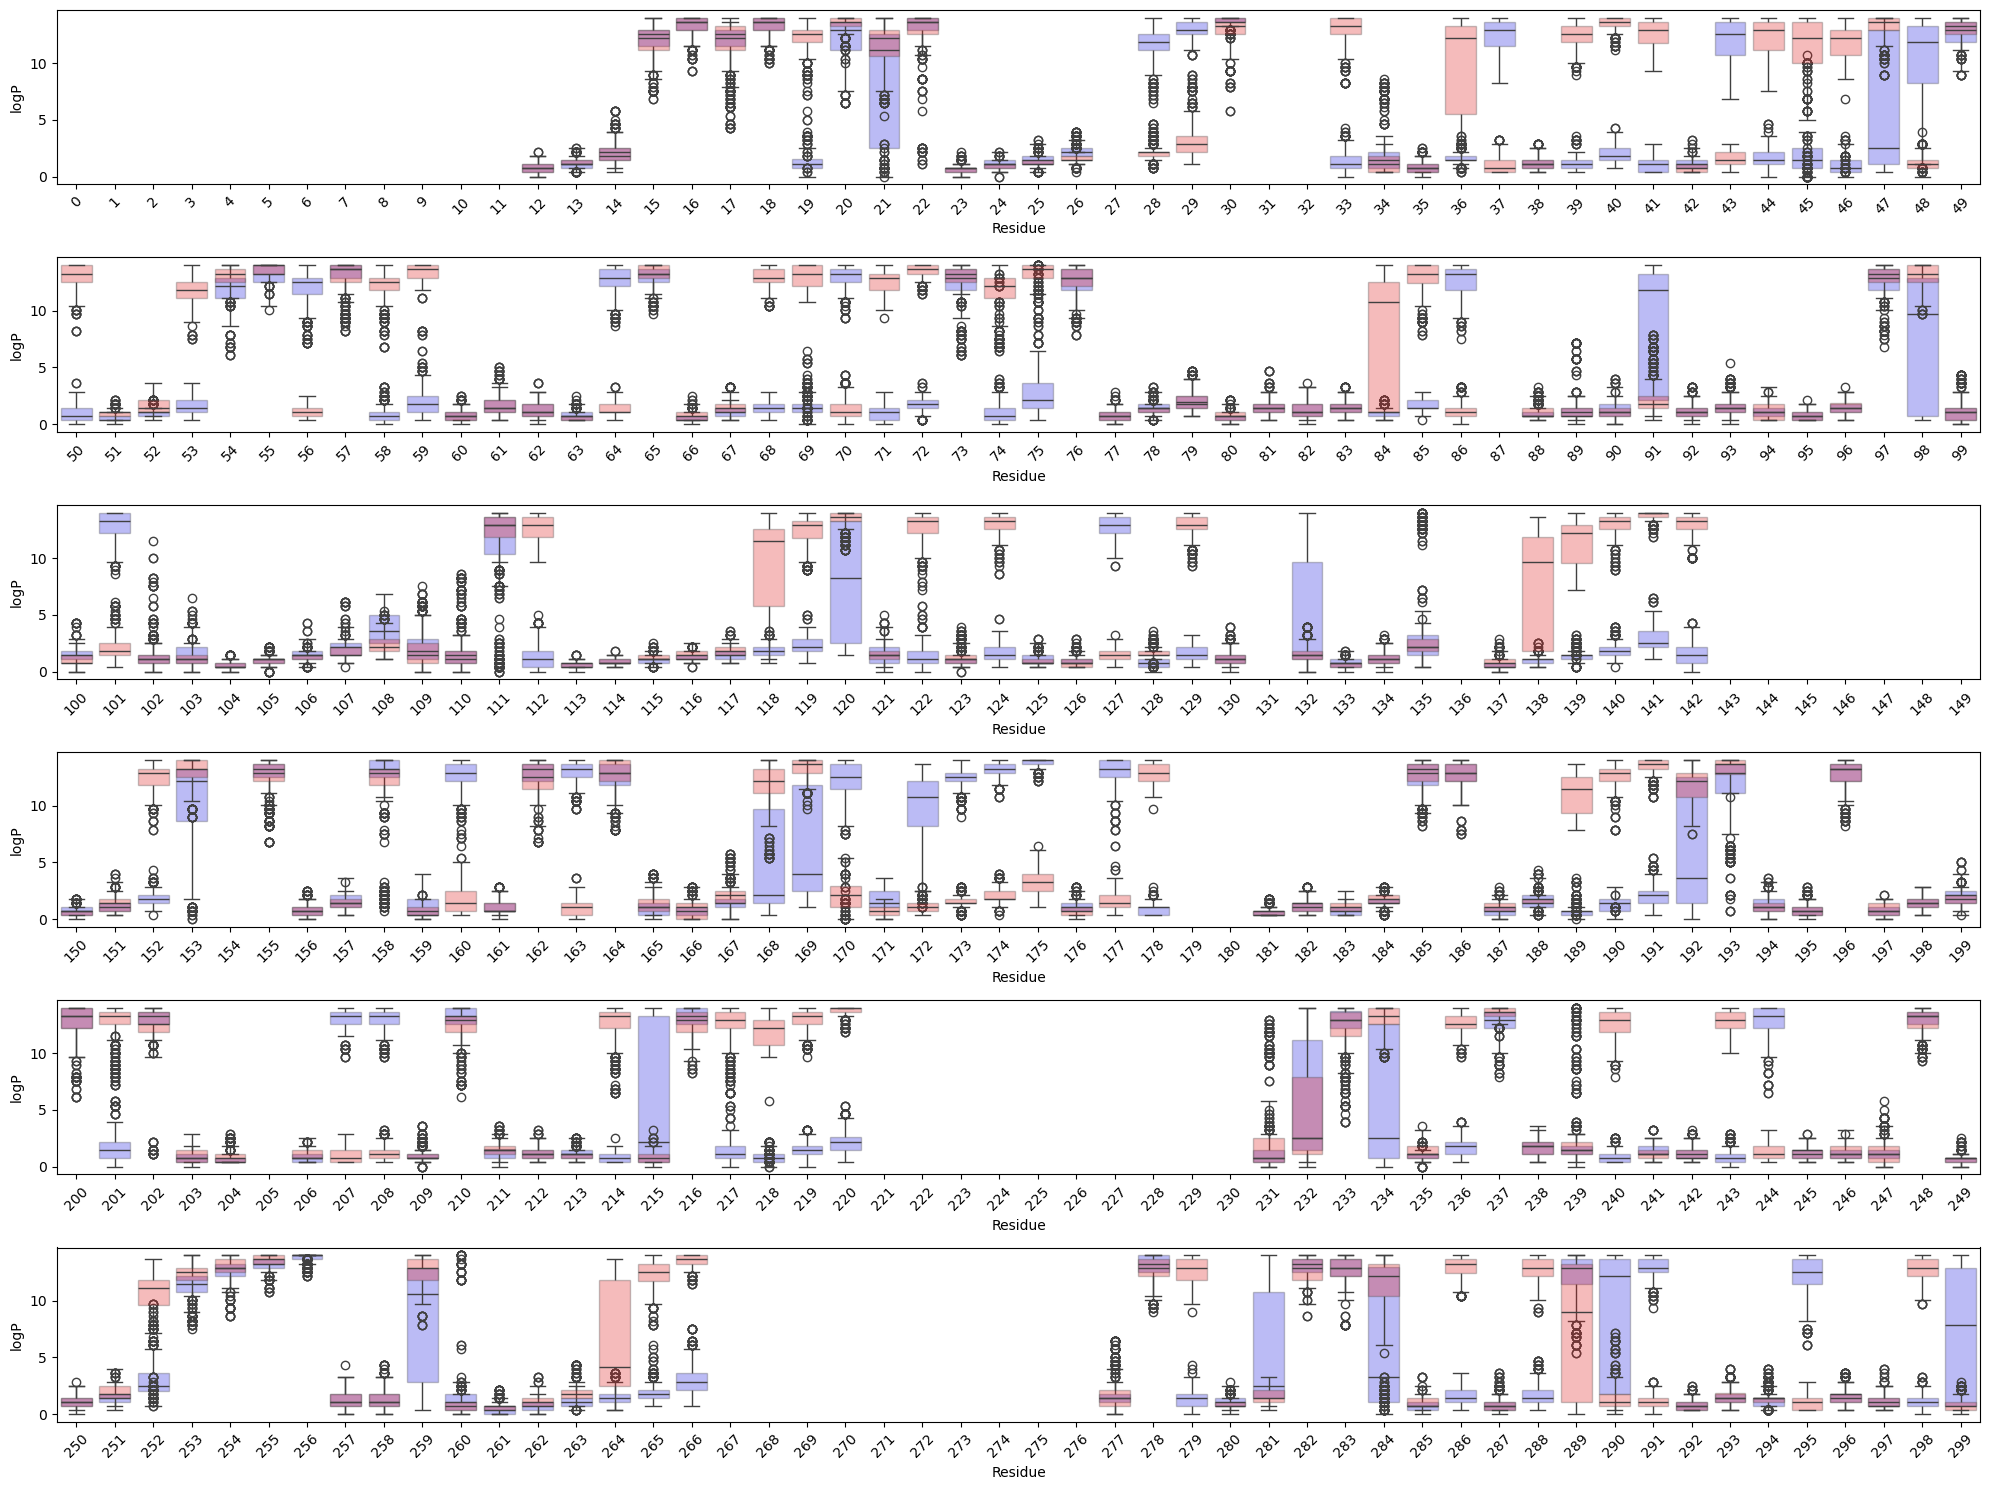

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplot(data1, data2, ax, color1, color2, box_alpha, showfliers):
    sns.boxplot(data=data1, ax=ax, color=color1, boxprops=dict(alpha=box_alpha), showfliers=showfliers)
    sns.boxplot(data=data2, ax=ax, color=color2, boxprops=dict(alpha=box_alpha), showfliers=showfliers)
    #sns.violinplot(data=data1, ax=ax, color=color1, boxprops=dict(alpha=box_alpha))
    #sns.violinplot(data=data2, ax=ax, color=color2, boxprops=dict(alpha=box_alpha))



#data_slices = [
#    (slice(0, 100), slice(0, 100)),
#    (slice(100, 200), slice(100, 200)),
#    (slice(200, 300), slice(200, 300))
#]
#data_slices = [
#    (slice(0, 75), slice(0, 75)),
#    (slice(75, 150), slice(75, 150)),
#    (slice(150, 225), slice(150, 225)),
#    (slice(225, 300), slice(225, 300))
#]

data_slices = [
    (slice(0, 50), slice(0, 50)),
    (slice(50, 100), slice(50, 100)),
    (slice(100, 150), slice(100, 150)),
    (slice(150, 200), slice(150, 200)),
    (slice(200, 250), slice(200, 250)),
    (slice(250, 300), slice(250, 300))
]


fig, axes = plt.subplots(len(data_slices), 1, figsize=(20, 2.5*len(data_slices)))

colors = ("blue", "red")
box_alpha = 0.3
showfliers = True

for ax, (slice1, slice2) in zip(axes, data_slices):
    plot_boxplot(df_list[0].iloc[:, slice1], df_list[1].iloc[:, slice2], ax, *colors, box_alpha, showfliers)
    plt.setp(ax.get_xticklabels(), rotation=45)
    ax.set_xlabel("Residue")
    ax.set_ylabel("logP")

#plt.legend(["Apo(r)", "LIG(b)"], loc="upper right")
#plt.legend(["Apo(1025, r)", "Apo(1018, b)"], loc="upper right")
#plt.legend(["Ribose(1025, r)", "Ribose(1018, b)"], loc="upper right")
plt.tight_layout()

In [5]:
# Perform the t-test
#stat, pvalue = stats.ttest_ind(X, Y)
stat, pvalue = stats.ttest_ind(df_list[0].mean().dropna(), 
                               df_list[1].mean().dropna())

# Print the results
print("t-test statistic:", stat)
print("p-value:", pvalue)

t-test statistic: -2.650550157787648
p-value: 0.008265842421315684


In [6]:
# KL divergence
from scipy.stats import entropy

entropy_pq = entropy(df_list[0], df_list[1])

In [7]:
if_below = entropy_pq < 0.1
np.where(if_below)

(array([ 15,  16,  17,  18,  20,  22,  26,  28,  29,  30,  40,  43,  49,
         53,  54,  55,  57,  65,  68,  72,  73,  76,  85,  97, 115, 116,
        117, 119, 124, 129, 140, 141, 152, 155, 162, 164, 173, 174, 175,
        185, 186, 191, 193, 196, 200, 202, 210, 216, 220, 233, 236, 237,
        248, 253, 254, 255, 256, 265, 266, 278, 282, 283, 306, 311, 315,
        316, 317, 318, 320, 321, 322, 328, 330, 331, 332]),)

<Axes: xlabel='289', ylabel='Count'>

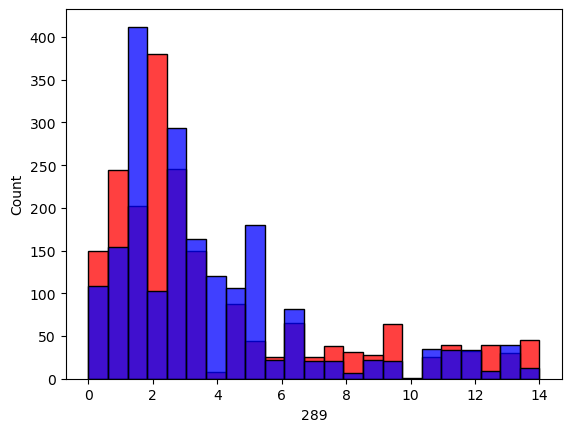

In [11]:
sns.histplot(df_list[0][289], color='red')
sns.histplot(df_list[1][289], color='blue')

<Axes: ylabel='Count'>

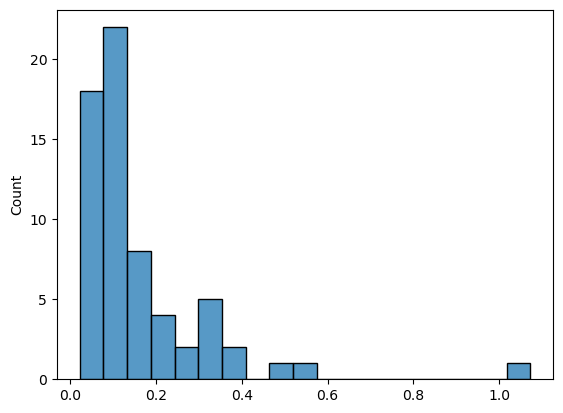

In [12]:
sns.histplot(entropy_pq)

<Axes: ylabel='Count'>

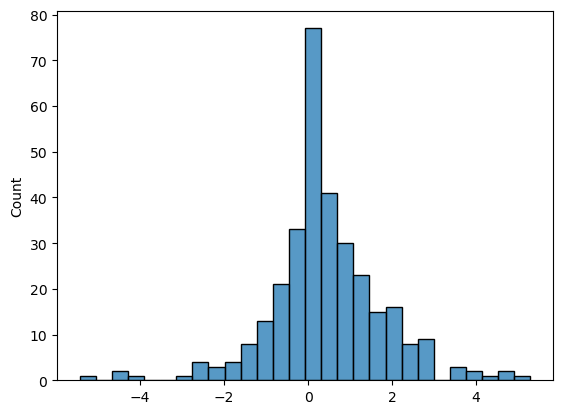

In [14]:
#diff_1 = df.where((diff.mean() - diff.std() < 0 ) & (diff.mean() + diff.std()>0), 0)

#sns.histplot(diff)
sns.histplot(diff_mean)

In [16]:
diff_df = pd.DataFrame(diff_mean)
diff_df.columns = ['diff_mean']
diff_df['residue'] = diff_df.index+1

In [18]:
diff_df.to_csv('bayseianhdx_logP_ADP-PEP_diff_mean.csv')

In [8]:
def plot_on_pdb(bfactor_array: np.array, pdb_infile, pdb_outfile=None):
   
    if not isinstance(bfactor_array, np.ndarray):
        bfactor_array = np.array(bfactor_array)
        
    import MDAnalysis
    u = MDAnalysis.Universe(pdb_infile)

    if pdb_outfile is None:
        pdb_outfile = pdb_infile[:-4] + "_bfactor.pdb"

    protein = u.select_atoms('protein')

    if len(bfactor_array) != protein.residues.n_residues:
        print('residue num:', protein.residues.n_residues)
        print('bfactor_array length:', len(bfactor_array))
        raise ValueError("bfactor_array must be the same length as the number of residues in the pdb file")

    for idx, res in enumerate(protein.residues):
        if np.isnan(bfactor_array[idx]):
            res.atoms.tempfactors = 0
        else:
            res.atoms.tempfactors = bfactor_array[idx]
    u.atoms.write(pdb_outfile)



In [13]:
plot_on_pdb(df_list[0].mean()[25:], "./structures/2dri_protein.pdb", pdb_outfile='./structures/2dri_protein_bfactor_apo.pdb')